This is a hello world CNN to show that not only can CNN distinguish the original images, but their Radon transform as well.

In [285]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import random
from skimage.transform import radon, rescale

We generate some easy toy data, one thousand $200\times 200$ 0-1 images and around half of them circle, the other half rectangle. We also calculate their Radon tranform.

We will use 900 for traning and the other 100 for testing.

In [286]:
def generate_toy_image(label):
    theta = numpy.linspace(0., 180., 200, endpoint=False)
    temp_image = numpy.zeros((200,200))
    
    # label 0 for rectangle and 1 for circle
    if label == 0:
        center_x = random.randrange(60,140)
        center_y = random.randrange(60,140)
        r = random.randrange(10,35)
        for j in range(image_size):
            for k in range(image_size):
                if (j-center_x)**2 + (k-center_y)**2 < r**2:
                    temp_image[j][k] = 1
                else:
                    temp_image[j][k] = 0
    else:
        x1 = random.randrange(60,140)
        dx = random.randrange(10,35)
        y1 = random.randrange(60,140)
        dy = random.randrange(10,35)
    
        for j in range(x1, x1+dx+1):
            for k in range(y1,y1+dy+1):
                temp_image[j][k] = 1

    # also calculate its Radon transform
    temp_radon = radon(temp_image, theta=theta) 
    return[temp_image,temp_radon]

N = 1000
N_train = 900

image = torch.zeros([N,1,200,200])
radondata = torch.zeros([N,1,200,200])
label = torch.zeros([N,1])

for i in range(N):
    temp_label =  1.0 if random.random() > 0.5 else 0.0
    [temp_image, temp_radon] = generate_toy_image(temp_label)
    image[i,0,:,:] = torch.tensor(temp_image)
    radondata[i,0,:,:] = torch.tensor(temp_radon)
    label[i,0] = temp_label

A sample image and its Radon transform

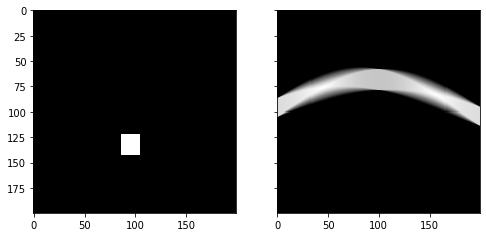

In [287]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.imshow(image[0,0,:,:].numpy(), cmap=plt.cm.Greys_r)
ax2.imshow(radondata[0,0,:,:].numpy(), cmap=plt.cm.Greys_r)

Define our CNN and trainning process.

In [288]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(5, 10, 2)
        self.fc1 = nn.Linear(10 * 12 * 12, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out_act(x)
        return x

In [289]:
def train_epoch(x, y, model, opt, criterion, batch_size=50):
    losses = []
    for beg_i in range(0, x.size(0), batch_size):
        x_batch = x[beg_i:beg_i + batch_size, :]
        y_batch = y[beg_i:beg_i + batch_size, :]
        
        opt.zero_grad()
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

Train the model on the first 900 original pictures. The success rate on the training set is 86%, which can be increased to 99% if set number of epochs to 10.

In [303]:
net1 = Net()
opt1 = optim.Adam(net1.parameters(), lr=0.001, betas=(0.9, 0.999))
lose_func1 = nn.BCELoss()

e_losses = []
num_epochs = 5
train_data = image[0:N_train]
train_label = label[0:N_train]

for e in range(num_epochs):
    e_losses.append(train_epoch(train_data, train_label, net1, opt1, lose_func1))

model_label = net1(train_data)
correct_count = 0
for i in range(train_data.shape[0]):
    if (1.0 if model_label[i][0].item() > 0.5 else 0.0) == train_label[i][0].item():
        correct_count = correct_count + 1

print(correct_count/train_data.shape[0])

0.8633333333333333


The error curve for the first epoch.

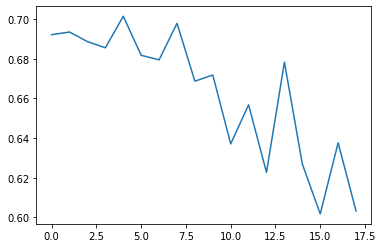

In [304]:
import matplotlib.pyplot as plt
plt.plot(e_losses[0])

Get similar success rate on testing set.

In [305]:
test_data = image[N_train :]
test_label = label[N_train :]
model_label = net1(test_data)

correct_count = 0
for i in range(test_data.shape[0]):
    if (1.0 if model_label[i][0].item() > 0.5 else 0.0) == test_label[i][0].item():
        correct_count = correct_count + 1

print(correct_count/test_data.shape[0])
    

0.86


Train the second CNN to classify images' Radon transform. With the same number of iterations, the success rate is 100%.

In [294]:
net2 = Net()
opt2 = optim.Adam(net2.parameters(), lr=0.001, betas=(0.9, 0.999))
lose_func2 = nn.BCELoss()
e_losses_radon = []
num_epochs = 5
train_data = radondata[0:N_train]
train_label = label[0:N_train]

for e in range(num_epochs):
    e_losses.append(train_epoch(train_data, train_label, net2, opt2, lose_func2))

model_label = net2(train_data)
correct_count = 0
for i in range(train_data.shape[0]):
    if (1.0 if model_label[i][0].item() > 0.5 else 0.0) == train_label[i][0].item():
        correct_count = correct_count + 1

print(correct_count/train_data.shape[0])

1.0


The error curve for the first epoch

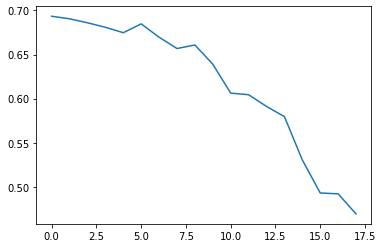

In [278]:
import matplotlib.pyplot as plt
plt.plot(e_losses[0])

Also get 100% success rate on the testing set for Radon images.

In [296]:
test_data = radondata[N_train :]
test_label = label[N_train :]
model_label = net2(test_data)

correct_count = 0
for i in range(test_data.shape[0]):
    if (1.0 if model_label[i][0].item() > 0.5 else 0.0) == test_label[i][0].item():
        correct_count = correct_count + 1

print(correct_count/test_data.shape[0])

1.0


Suprisingly it seems CNN can distinguish between Radon images better than the original one.

One explaination might be for rectangle Radon images, you can see four sin curves a

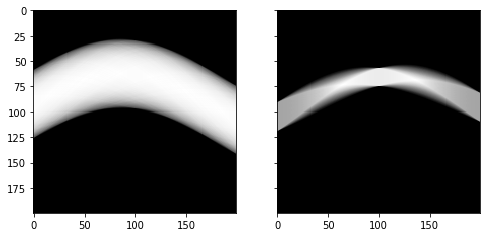

In [300]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.imshow(test_data[5,0,:,:].numpy(), cmap=plt.cm.Greys_r)
ax2.imshow(test_data[6,0,:,:].numpy(), cmap=plt.cm.Greys_r)